In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
with_mask_files=os.listdir("/content/drive/MyDrive/archive (1)/data/with_mask/")
without_mask_files=os.listdir("/content/drive/MyDrive/archive (1)/data/without_mask/")

In [ ]:
len(with_mask_files)

3725

In [ ]:
len(without_mask_files)

3828

In [ ]:
with_mask_label=[1]*len(with_mask_files)
without_mask_label=[0]*len(without_mask_files)
labels=with_mask_label+without_mask_label

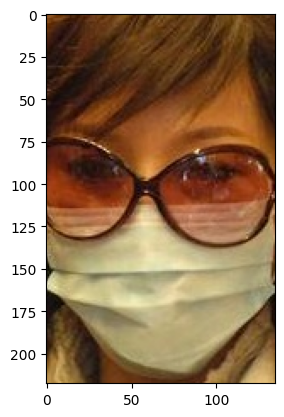

In [ ]:
img=mpimg.imread('/content/drive/MyDrive/archive (1)/data/with_mask/with_mask_10.jpg')
plt.imshow(img)

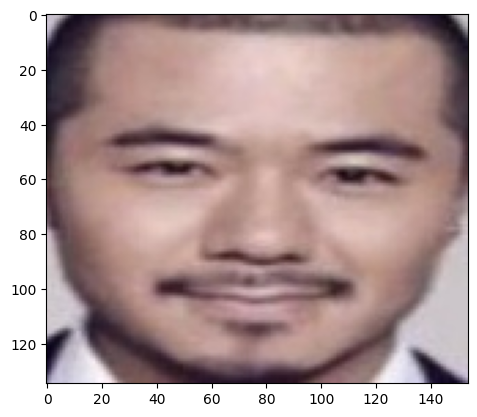

In [ ]:
img=mpimg.imread('/content/drive/MyDrive/archive (1)/data/without_mask/without_mask_10.jpg')
plt.imshow(img)

Image processing

In [ ]:
with_mask_path="/content/drive/MyDrive/archive (1)/data/with_mask/"
data=[]
for img_file in with_mask_files:
  image=Image.open(with_mask_path+img_file)
  image=image.resize((128,128))
  image=image.convert('RGB')
  image=np.array(image)
  data.append(image)

without_mask_path="/content/drive/MyDrive/archive (1)/data/without_mask/"
for img_file in without_mask_files:
  image=Image.open(without_mask_path+img_file)
  image=image.resize((128,128))
  image=image.convert('RGB')
  image=np.array(image)
  data.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
len(data)

7553

In [ ]:
data[0].shape

(128, 128, 3)

Converting image list and label list to numpy arrays

In [ ]:
X=np.array(data)
Y=np.array(labels)

In [ ]:
print(X.shape)
print(Y.shape)

(7553, 128, 128, 3)
(7553,)


Train test split

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2,random_state=2)


In [ ]:
X_train_scaled=X_train/255
X_test_scaled=X_test/255

Building cnn model

In [ ]:
import tensorflow as tf

from tensorflow import keras

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def resnet_block(x, filters, downsample=False):
    identity = x

    # First block
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1 if not downsample else 2, 1 if not downsample else 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second block
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if downsample:
        identity = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='valid')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

# Input layer
input_layer = Input(shape=(128, 128, 3))

# Convolutional layers
x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)

x = resnet_block(x, filters=128, downsample=True)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=128)

x = resnet_block(x, filters=256, downsample=True)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)

x = resnet_block(x, filters=512, downsample=True)
x = resnet_block(x, filters=512)
x = resnet_block(x, filters=512)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for binary classification (mask or no mask)
output_layer = Dense(num_classes, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


In [ ]:
history=model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
170/170 [==============================] - 70s 211ms/step - loss: 0.6859 - acc: 0.7326 - val_loss: 2.2144 - val_acc: 0.6000
Epoch 2/5
170/170 [==============================] - 33s 194ms/step - loss: 0.3429 - acc: 0.8668 - val_loss: 0.6735 - val_acc: 0.7752
Epoch 3/5
170/170 [==============================] - 34s 199ms/step - loss: 0.2517 - acc: 0.9047 - val_loss: 0.3859 - val_acc: 0.8793
Epoch 4/5
170/170 [==============================] - 34s 198ms/step - loss: 0.2250 - acc: 0.9229 - val_loss: 0.3169 - val_acc: 0.8992
Epoch 5/5
170/170 [==============================] - 34s 197ms/step - loss: 0.2000 - acc: 0.9303 - val_loss: 0.2566 - val_acc: 0.8926


Model evaluation

In [ ]:
loss,accuracy=model.evaluate(X_test_scaled, Y_test)
print("Test Accuracy:", accuracy)

48/48 [==============================] - 4s 79ms/step - loss: 0.2234 - acc: 0.9146
Test Accuracy: 0.9146260619163513


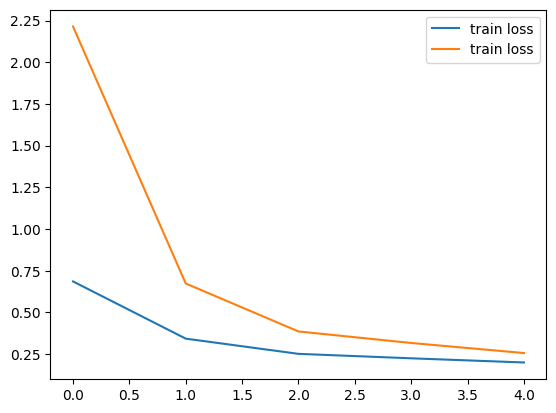

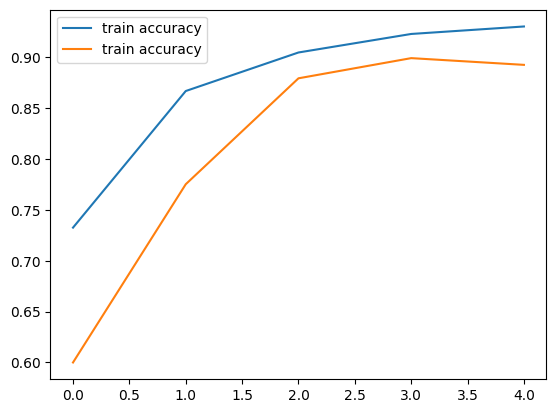

In [ ]:
h=history
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='train loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='train accuracy')
plt.legend()
plt.show()

Predictive system

In [ ]:
input_image_path=input("Path of image to predict")

input_image=cv2.imread(input_image_path)
cv2_imshow(input_image)
input_image_resized=cv2.resize(input_image, (128,128))
input_image_scaled=input_image_resized/255
input_image_reshaped=np.reshape(input_image_scaled,(1,128,128,3))
input_prediction=model.predict(input_image_reshaped)

print(input_prediction)

input_pred_label=np.argmax(input_prediction)
print(input_pred_label)

if(input_pred_label==1):
  print("Person in image is waering mask")
else:
  print("No mask detetcted")

KeyboardInterrupt: ignored